In [1]:
from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

from shapely.geometry import Point, Polygon
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)
pd.options.display.max_rows = 1000

plt.style.use('seaborn-darkgrid')

In [2]:
input_dir = '../../data/final'

df = pd.read_csv(os.path.join(input_dir, 'df_for_model.csv'))

print(df.head())

              datetime  pct_blackout  wind_forest_cover        t2m  \
0  2014-11-17 17:00:00           0.0                0.0  295.09723   
1  2014-11-29 17:00:00           0.0                0.0  293.04870   
2  2014-11-30 22:00:00           0.0                0.0  289.83447   
3  2014-11-13 07:00:00           0.0                0.0  297.14110   
4  2014-12-31 15:00:00           0.0                0.0  296.46838   

             tp  wind_speed  station_id climate_zone_code  
0  5.645638e-04    1.310930         495                Aw  
1  0.000000e+00    2.215274         495                Aw  
2  4.351137e-07    2.000125         495                Aw  
3  6.666072e-04    3.900476         495                Aw  
4  2.732359e-06    2.988735         495                Aw  


In [26]:

df_station276 = df[df['station_id'] == 276]

# add a column with the date as a datetime object
df_station276['date'] = pd.to_datetime(df_station276['datetime']).dt.date

# sort the values by datetime
df_station276 = df_station276.sort_values('datetime')
test = df_station276.head(25)


/var/folders/38/ttqg2y215g16g2ng7jd502_c0000gn/T/ipykernel_39905/709234110.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_station276['date'] = pd.to_datetime(df_station276['datetime']).dt.date


In [ ]:
# print(test)

test.info()



In [35]:

test.describe()

test.t2m.sum()
test.tp.sum()

1.964175955e-05

In [93]:

# print the date range of station 276
print(df_station276['date'].min())
print(df_station276['date'].max())



2016-11-24
2017-10-23


In [3]:
df.index

RangeIndex(start=0, stop=7044379, step=1)

In [23]:

df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date

df['blackout_time_minutes'] = df['pct_blackout'] * 60



daily_aggregated = (
    df.groupby(['station_id', 'date'])
    .agg(
        t2m_avg=('t2m', 'mean'),
        t2m_max=('t2m', 'max'),
        t2m_min=('t2m', 'min'),
        t2m_median=('t2m', 'median'),
        tp_avg=('tp', 'mean'),
        tp_max=('tp', 'max'),
        tp_min=('tp', 'min'),
        tp_median=('tp', 'median'),
        tp_sum=('tp', 'sum'),
        wind_speed_avg=('wind_speed', 'mean'),
        wind_speed_max=('wind_speed', 'max'),
        wind_speed_min=('wind_speed', 'min'),
        wind_speed_median=('wind_speed', 'median'),
        daily_blackout_time=('blackout_time_minutes', 'sum')
    )
    .reset_index()
)

print(daily_aggregated)

        station_id        date     t2m_avg    t2m_max    t2m_min  t2m_median  \
0                1  2016-07-08  296.166617  299.24072  293.98560  295.799435   
1                1  2016-07-09  295.860636  298.48560  294.01050  295.375610   
2                1  2016-07-10  295.965729  299.11914  293.96020  295.257570   
3                1  2016-07-11  295.709585  298.28320  293.79126  295.232055   
4                1  2016-07-12  296.420979  298.74194  293.71875  296.584840   
...            ...         ...         ...        ...        ...         ...   
296641         571  2023-04-09  297.250640  302.45337  291.08533  297.660130   
296642         571  2023-04-10  297.868741  304.51904  290.74017  298.486955   
296643         571  2023-04-11  298.100672  304.35815  290.45853  299.038490   
296644         571  2023-04-12  301.331311  304.48730  290.49927  303.397580   
296645         571  2023-04-13  293.290280  293.29028  293.29028  293.290280   

              tp_avg        tp_max     

In [25]:
# sample a station, and a date for this station, print result, to validate

station_id = 276
date = '2016-11-24'

print(daily_aggregated[(daily_aggregated['station_id'] == station_id)].head(10))

        station_id        date     t2m_avg    t2m_max    t2m_min  t2m_median  \
137958         276  2016-11-24  286.015555  293.49487  277.78180  286.867675   
137959         276  2016-11-25  286.654386  295.03540  278.31180  286.646730   
137960         276  2016-11-26  288.208223  295.74610  279.21980  288.474680   
137961         276  2016-11-27  287.099203  293.66528  280.93268  286.287045   
137962         276  2016-11-28  286.458073  293.89624  279.02190  285.838490   
137963         276  2016-11-29  285.153306  292.18164  277.75717  285.072125   
137964         276  2016-11-30  285.386482  291.16700  278.83188  285.296625   
137965         276  2016-12-01  285.222954  289.81152  280.84003  284.331910   
137966         276  2016-12-02  284.666135  290.15967  278.86760  284.465940   
137967         276  2016-12-03  285.139967  292.21777  278.15400  285.260840   

              tp_avg        tp_max    tp_min     tp_median        tp_sum  \
137958  7.472845e-07  1.714914e-06  0.00000

In [5]:
daily_aggregated.head()

daily_aggregated.info()

daily_aggregated.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296646 entries, 0 to 296645
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   station_id           296646 non-null  int64  
 1   date                 296646 non-null  object 
 2   t2m_avg              296646 non-null  float64
 3   t2m_max              296646 non-null  float64
 4   t2m_min              296646 non-null  float64
 5   t2m_median           296646 non-null  float64
 6   tp_avg               296646 non-null  float64
 7   tp_max               296646 non-null  float64
 8   tp_min               296646 non-null  float64
 9   tp_median            296646 non-null  float64
 10  tp_sum               296646 non-null  float64
 11  wind_speed_avg       296646 non-null  float64
 12  wind_speed_max       296646 non-null  float64
 13  wind_speed_min       296646 non-null  float64
 14  wind_speed_mid       296646 non-null  float64
 15  daily_blackout_ti

,station_id,t2m_avg,t2m_max,t2m_min,t2m_median,tp_avg,tp_max,tp_min,tp_median,tp_sum,wind_speed_avg,wind_speed_max,wind_speed_min,wind_speed_mid,daily_blackout_time
count,296646.000000,296646.000000,296646.000000,296646.000000,296646.000000,2.966460e+05,296646.000000,296646.000000,2.966460e+05,296646.000000,296646.000000,296646.000000,296646.000000,296646.000000,296646.000000
mean,300.045590,298.246889,303.615679,293.304242,297.694111,1.699044e-03,0.004362,0.000127,1.798408e-03,0.040297,2.390413,3.659780,1.225748,2.442764,149.120062
std,171.500105,4.972015,5.193256,5.484422,5.039082,4.679553e-03,0.010671,0.000763,5.056173e-03,0.111314,1.060671,1.392666,0.987312,1.111939,267.983063
min,1.000000,260.648790,267.214900,253.497850,259.855655,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.071253,0.071253,0.000337,0.071253,0.000000
25%,155.000000,295.497569,300.399622,289.863985,294.922947,5.335921e-07,0.000002,0.000000,4.261731e-07,0.000013,1.623682,2.610852,0.440368,1.618676,0.000000
50%,298.000000,298.648843,303.480960,294.365480,298.108502,3.637745e-05,0.000165,0.000000,1.846347e-05,0.000856,2.183330,3.432287,0.968458,2.216224,16.000000
75%,458.000000,301.362574,306.681112,297.440920,300.822353,1.206418e-03,0.003650,0.000003,1.193026e-03,0.028497,2.926220,4.468388,1.775715,3.033623,167.000000
max,571.000000,316.477905,319.621100,316.098880,316.477905,1.890805e-01,0.257208,0.086591,2.150447e-01,4.537932,10.628433,15.959517,8.481403,10.120508,1440.000000


In [6]:


daily_aggregated.to_csv(os.path.join(input_dir, 'daily_aggregated.csv'), index=False)


In [7]:

daily_aggregated['station_id'].nunique()

516

In [8]:

daily_aggregated.groupby('station_id').size().sort_values(ascending=True)
# daily_aggregated.groupby('station_id').size().plot(kind='hist', bins=50)
# plt.show()

# plt.savefig('station_id_hist.png', dpi=400)




station_id
518       6
563       7
386      10
58       12
130      12
103      15
134      15
166      17
183      22
559      22
123      23
167      24
423      24
269      28
385      36
394      37
37       37
420      43
256      46
136      50
100      50
474      51
454      52
351      55
281      57
409      62
307      63
505      63
62       66
264      68
142      70
54       71
405      73
254      75
216      76
165      77
370      78
326      79
291      79
9        81
174      81
245      82
379      86
152      87
10       88
249      91
378      91
132      92
504      93
293      95
519      96
514      98
300     100
241     100
525     104
515     105
398     106
280     108
82      109
78      109
524     109
513     110
512     112
236     112
528     113
338     115
178     115
517     117
527     118
523     120
511     120
182     120
113     121
522     122
521     122
526     122
520     122
516     122
46      123
94      128
460     133
390     136
192  

In [9]:


daily_aggregated_filtered = daily_aggregated[daily_aggregated.groupby('station_id').station_id.transform('size') > 180]


In [10]:

daily_aggregated[daily_aggregated.groupby(
    'station_id').station_id.transform('size') > 365]['station_id'].nunique()


282

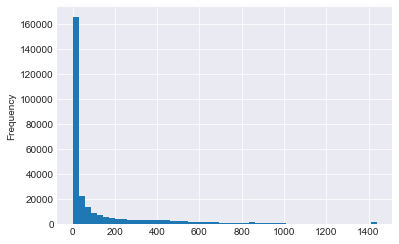

In [11]:
daily_aggregated['daily_blackout_time'].plot(kind='hist', bins=50)

plt.savefig('daily_blackout_time_hist.png', dpi=400)

In [6]:
# read climate zone in df_final_geo_518

df_final_geo_518 = pd.read_csv(os.path.join(input_dir, 'df_final_geo_518.csv'))

df_final_geo_518.head()


/var/folders/38/ttqg2y215g16g2ng7jd502_c0000gn/T/ipykernel_24519/1310805567.py:3: DtypeWarning: Columns (8,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_final_geo_518 = pd.read_csv(os.path.join(input_dir, 'df_final_geo_518.csv'))


,Unnamed: 0,index_x,datetime,Location name_x,ESMI_ID,District,State,Category,Connection Type_x,Lat,Lon,t2m,u10,v10,tp,date,time,station_id,index_y,pct_blackout,wind_speed,Connection Type_y,climate_zone_DN,climate_zone_name,climate_zone_code,tree2000,gain,lossyear,geometry,climate_zone_code_2,wind_forest_cover
0,0,2569489,2014-11-17 17:00:00,Vijay Nagar,NaN,Hyderabad,Telangana,State Capital,Domestic,17.394295,78.451016,295.09723,-1.271197,-0.320305,5.645638e-04,20141117,1700,495,7239294,0.0,1.310930,Domestic,3.0,"Tropical, savannah",Aw,0.0,0.0,2000.0,POINT (78.45101625 17.39429481),Aw,0.0
1,1,2569493,2014-11-29 17:00:00,Vijay Nagar,NaN,Hyderabad,Telangana,State Capital,Domestic,17.394295,78.451016,293.04870,-1.548639,-1.584031,0.000000e+00,20141129,1700,495,7239582,0.0,2.215274,Domestic,3.0,"Tropical, savannah",Aw,0.0,0.0,2000.0,POINT (78.45101625 17.39429481),Aw,0.0
2,2,2569500,2014-11-30 22:00:00,Vijay Nagar,NaN,Hyderabad,Telangana,State Capital,Domestic,17.394295,78.451016,289.83447,-1.289795,-1.528702,4.351137e-07,20141130,2200,495,7239611,0.0,2.000125,Domestic,3.0,"Tropical, savannah",Aw,0.0,0.0,2000.0,POINT (78.45101625 17.39429481),Aw,0.0
3,3,2569503,2014-11-13 07:00:00,Vijay Nagar,NaN,Hyderabad,Telangana,State Capital,Domestic,17.394295,78.451016,297.14110,-3.871719,0.472760,6.666072e-04,20141113,700,495,7239188,0.0,3.900476,Domestic,3.0,"Tropical, savannah",Aw,0.0,0.0,2000.0,POINT (78.45101625 17.39429481),Aw,0.0
4,4,2569506,2014-12-31 15:00:00,Vijay Nagar,NaN,Hyderabad,Telangana,State Capital,Domestic,17.394295,78.451016,296.46838,-2.901352,0.717420,2.732359e-06,20141231,1500,495,7240348,0.0,2.988735,Domestic,3.0,"Tropical, savannah",Aw,0.0,0.0,2000.0,POINT (78.45101625 17.39429481),Aw,0.0


In [14]:
daily_aggregated = pd.read_csv(os.path.join(input_dir, 'daily_aggregated.csv'))

climate_zone = df_final_geo_518[['station_id', 'climate_zone_code']].drop_duplicates(inplace=True)

climate_zone.to_csv(os.path.join(input_dir, 'climate_zone.csv'), index=False)


/var/folders/38/ttqg2y215g16g2ng7jd502_c0000gn/T/ipykernel_24519/847734868.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  climate_zone.drop_duplicates(inplace=True)


In [15]:
# join climate zone to daily_aggregated by station_id

daily_aggregated = daily_aggregated.merge(climate_zone, on='station_id', how='left')

daily_aggregated.head()


,station_id,date,t2m_avg,t2m_max,t2m_min,t2m_median,tp_avg,tp_max,tp_min,tp_median,tp_sum,wind_speed_avg,wind_speed_max,wind_speed_min,wind_speed_mid,daily_blackout_time,climate_zone_code
0,1,2016-07-08,296.166617,299.24072,293.98560,295.799435,0.000928,0.003314,7.747673e-06,0.001118,0.022261,5.699010,7.550663,4.363706,5.957185,25.0,Aw
1,1,2016-07-09,295.860636,298.48560,294.01050,295.375610,0.000463,0.001136,1.545996e-07,0.000534,0.011115,6.752629,8.633310,5.489735,7.061522,88.0,Aw
2,1,2016-07-10,295.965729,299.11914,293.96020,295.257570,0.000448,0.000678,5.487353e-06,0.000542,0.010748,7.102749,9.077559,5.863512,7.470536,81.0,Aw
3,1,2016-07-11,295.709585,298.28320,293.79126,295.232055,0.000235,0.000624,0.000000e+00,0.000271,0.005652,6.524960,8.474811,5.160284,6.817547,7.0,Aw
4,1,2016-07-12,296.420979,298.74194,293.71875,296.584840,0.000424,0.000655,8.772127e-06,0.000545,0.007633,6.024988,7.767821,4.536693,6.152257,409.0,Aw


In [17]:
# df daily_climate_zone_aggregated

# aggregate daily_aggregated by climate_zone_code

daily_climate_zone_aggregated = (
    daily_aggregated.groupby(['climate_zone_code', 'date'])
	.agg(
		t2m_avg=('t2m_avg', 'mean'),
		t2m_max=('t2m_max', 'mean'),
		t2m_min=('t2m_min', 'mean'),
		t2m_median=('t2m_median', 'mean'),
		tp_avg=('tp_avg', 'mean'),
		tp_max=('tp_max', 'mean'),
		tp_min=('tp_min', 'mean'),
		tp_median=('tp_median', 'mean'),
		tp_sum=('tp_sum', 'mean'),
		wind_speed_avg=('wind_speed_avg', 'mean'),
		wind_speed_max=('wind_speed_max', 'mean'),
		wind_speed_min=('wind_speed_min', 'mean'),
		wind_speed_mid=('wind_speed_mid', 'mean'),
		daily_blackout_time=('daily_blackout_time', 'mean')
	)
	.reset_index()
)

daily_climate_zone_aggregated.head()

,climate_zone_code,date,t2m_avg,t2m_max,t2m_min,t2m_median,tp_avg,tp_max,tp_min,tp_median,tp_sum,wind_speed_avg,wind_speed_max,wind_speed_min,wind_speed_mid,daily_blackout_time
0,Am,2015-01-06,298.235846,303.161780,294.069795,297.593107,1.452262e-04,2.456712e-04,6.984920e-10,2.367129e-04,0.003485,1.353999,3.205677,0.266642,1.736159,730.000000
1,Am,2015-01-07,296.496196,298.978563,294.370758,296.273405,5.286238e-05,1.518710e-04,2.904717e-05,5.365294e-05,0.000601,1.357236,2.229571,0.655642,1.442607,360.000000
2,Am,2015-01-08,298.317872,303.421677,293.761780,297.855639,2.925771e-06,5.408190e-05,0.000000e+00,4.854052e-07,0.000070,1.820246,3.427268,0.607156,2.017212,373.500000
3,Am,2015-01-09,297.263584,302.076889,293.145040,297.081551,3.890907e-07,1.627221e-06,0.000000e+00,2.434926e-07,0.000006,1.321302,2.744936,0.462835,1.603886,260.857143
4,Am,2015-01-10,298.175819,305.129263,292.255063,297.636090,5.727696e-07,8.623971e-07,0.000000e+00,8.584044e-07,0.000014,1.824160,3.004733,0.615823,1.810278,4.285714


In [18]:
# save daily_climate_zone_aggregated

daily_climate_zone_aggregated.to_csv(os.path.join(input_dir, 'daily_climate_zone_aggregated.csv'), index=False)


In [36]:



daily_climate_zone_aggregated['climate_zone_code'] = daily_climate_zone_aggregated['climate_zone_code'].replace('Cwa', 'Cw')
daily_climate_zone_aggregated['climate_zone_code'] = daily_climate_zone_aggregated['climate_zone_code'].replace('Cwb', 'Cw')

daily_climate_zone_aggregated.climate_zone_code.unique()
# daily_climate_zone_aggregated.index

# count the number of days for each climate zone

daily_climate_zone_aggregated.groupby('climate_zone_code').size()

climate_zone_code
Am     2634
Aw     3353
BSh    3294
Cw     3438
dtype: int64

In [38]:
print(daily_climate_zone_aggregated.head())

  climate_zone_code       date     t2m_avg     t2m_max     t2m_min  \
0                Am 2015-01-06  298.235846  303.161780  294.069795   
1                Am 2015-01-07  296.496196  298.978563  294.370758   
2                Am 2015-01-08  298.317872  303.421677  293.761780   
3                Am 2015-01-09  297.263584  302.076889  293.145040   
4                Am 2015-01-10  298.175819  305.129263  292.255063   

   t2m_median        tp_avg        tp_max        tp_min     tp_median  \
0  297.593107  1.452262e-04  2.456712e-04  6.984920e-10  2.367129e-04   
1  296.273405  5.286238e-05  1.518710e-04  2.904717e-05  5.365294e-05   
2  297.855639  2.925771e-06  5.408190e-05  0.000000e+00  4.854052e-07   
3  297.081551  3.890907e-07  1.627221e-06  0.000000e+00  2.434926e-07   
4  297.636090  5.727696e-07  8.623971e-07  0.000000e+00  8.584044e-07   

     tp_sum  wind_speed_avg  wind_speed_max  wind_speed_min  wind_speed_mid  \
0  0.003485        1.353999        3.205677        0.266642  

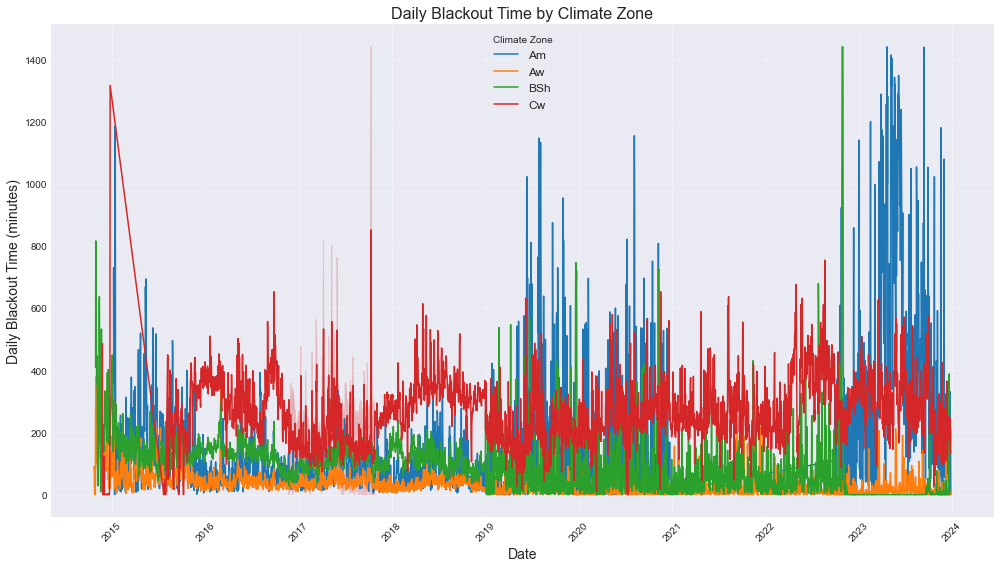

In [40]:
# Create a lineplot using seaborn
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=daily_climate_zone_aggregated,
    x='date',
    y='daily_blackout_time',
    hue='climate_zone_code',
    palette='tab10'  # Use a distinct color palette for different climate zones
)

# Customize the plot
plt.title('Daily Blackout Time by Climate Zone', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Daily Blackout Time (minutes)', fontsize=14)
plt.legend(title='Climate Zone', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()

plt.savefig('daily_blackout_time_by_climate_zone.png', dpi=400)

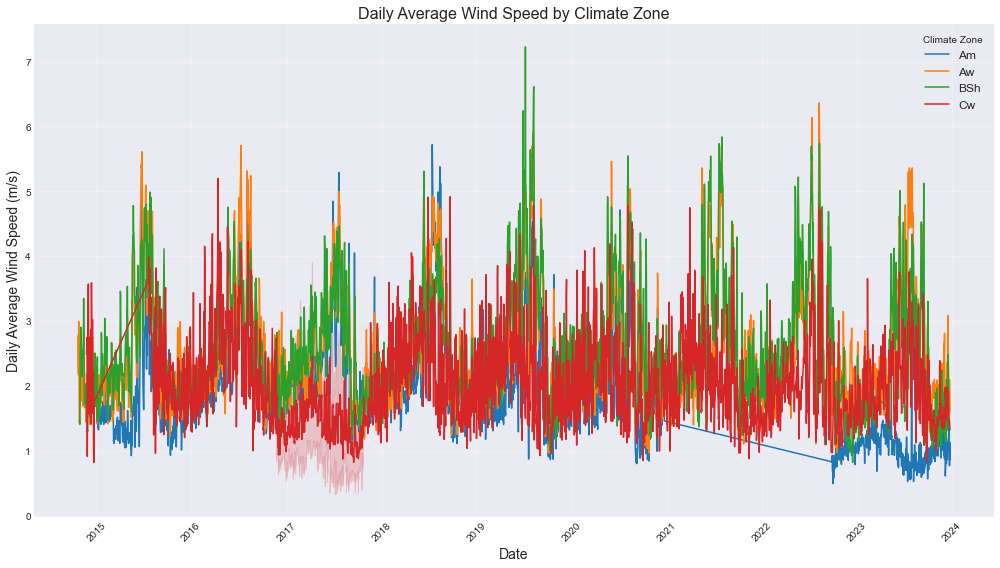

In [41]:
# in the same manner, plot the daily  average wind speed by climate zone


plt.figure(figsize=(14, 8))
sns.lineplot(
	data=daily_climate_zone_aggregated,
	x='date',
	y='wind_speed_avg',
	hue='climate_zone_code',
	palette='tab10'  # Use a distinct color palette for different climate zones
)

plt.title('Daily Average Wind Speed by Climate Zone', fontsize=16)

plt.xlabel('Date', fontsize=14)
plt.ylabel('Daily Average Wind Speed (m/s)', fontsize=14)
plt.legend(title='Climate Zone', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig('daily_wind_speed_by_climate_zone.png', dpi=400)


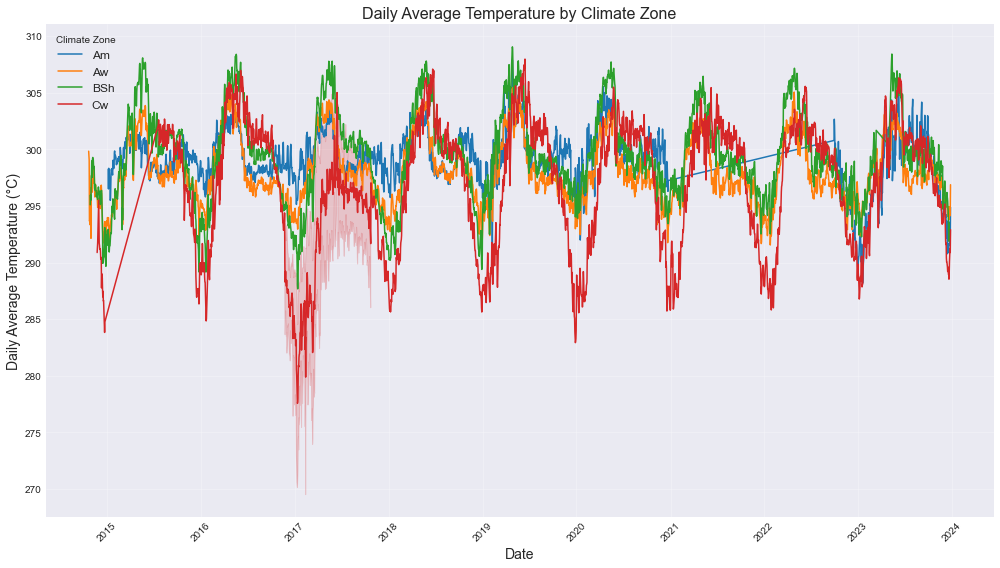

In [42]:
# plot daily average temperature by climate zone

plt.figure(figsize=(14, 8))
sns.lineplot(
	data=daily_climate_zone_aggregated,
	x='date',
	y='t2m_avg',
	hue='climate_zone_code',
	palette='tab10'  # Use a distinct color palette for different climate zones
)

plt.title('Daily Average Temperature by Climate Zone', fontsize=16)

plt.xlabel('Date', fontsize=14)
plt.ylabel('Daily Average Temperature (°C)', fontsize=14)
plt.legend(title='Climate Zone', fontsize=12)

plt.xticks(rotation=45)

plt.grid(alpha=0.3)

plt.tight_layout()

plt.savefig('daily_temperature_by_climate_zone.png', dpi=400)

